# 02b - Evaluate Classification Scores of Fine-tuned DistilBERT

In [1]:
import numpy as np
import pandas as pd

import torch
from datasets import load_dataset

from src import data, models, metrics

DATA_DIR = 'data/'
OUTPUT_DIR = 'output/distilbert/'
MODEL_NAME = 'distilbert_monitors_3epoch'
CLASSES = ['Monitor', 'Tv', 'Noise']


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


## Create DistilBERT model and tokenizer

In [2]:
# create model and load pre-trained checkpoint
# use fine-tuned checkpoint
net = models.DistilBERT(pretrained_checkpoint=OUTPUT_DIR + MODEL_NAME)

In [3]:
print(f'Number of trainable parameters: {net.num_trainable_params():,}')

Number of trainable parameters: 66,955,779


## Example of Classification

Classify one example to verify that the code executes without errors.

In [4]:
x = '32 inch curved screen 144hz monitor 1k 2k 4k fhd ips curved lcd pc hd-mi power vga cable'
net.predict_sample(x, return_dict=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[{'Monitor': 6.810817e-05, 'Tv': 4.9609378e-05, 'Noise': 0.9998822}]

## Load the Data

In [5]:
# load datasets
datasets = load_dataset('csv', data_files={
    # 'train': DATA_DIR + 'monitors_classification_202107_train.csv',
    # 'validation': DATA_DIR + 'monitors_classification_202107_val.csv',
    'test': DATA_DIR + 'monitors_classification_202107_test.csv'
})

# tokenize datasets
tokenized_datasets = net.tokenize_dataset(datasets)

datasets

Using custom data configuration default-c0d7b63d8a6cd083


0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /home/ec2-user/.cache/huggingface/datasets/csv/default-c0d7b63d8a6cd083/0.0.0/e138af468cb14e747fb46a19c787ffcfa5170c821476d20d5304287ce12bbc23. Subsequent calls will reuse this data.


  0%|          | 0/28 [00:00<?, ?ba/s]

DatasetDict({
    test: Dataset({
        features: ['inp', 'trg', 'metadata'],
        num_rows: 28000
    })
})

## Evaluate the Results

In [6]:
# get test predictions
out = net.predict(tokenized_datasets['test'], bs=64, log_level='error')

In [7]:
# size of the test set
len(tokenized_datasets['test'])

28000

### Classification Report with Precision, Recall and F1-Score

In [8]:
from sklearn.metrics import classification_report, confusion_matrix


pd.DataFrame(classification_report(
    out.label_ids,
    out.predictions,
    target_names=net.config.id2label.values(),
    output_dict=True
)).T

,precision,recall,f1-score,support
Monitor,0.988563,0.994826,0.991685,17203.000000
Tv,0.973225,0.984688,0.978923,3396.000000
Noise,0.982763,0.962978,0.972770,7401.000000
accuracy,0.985179,0.985179,0.985179,0.985179
macro avg,0.981517,0.980831,0.981126,28000.000000
weighted avg,0.985170,0.985179,0.985137,28000.000000


### Confusion Matrix

<AxesSubplot:>

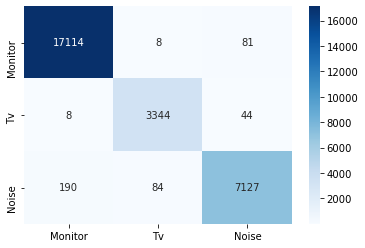

In [9]:
import seaborn as sns


cm = pd.DataFrame(
    confusion_matrix(out.label_ids, out.predictions),
    index=net.config.id2label.values(),
    columns=net.config.id2label.values())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

### Evaluate Error Records

In [10]:
df = datasets['test'].to_pandas()
df['pred'] = net.id2label(out.predictions)

In [11]:
df.loc[df['trg'] != df['pred'], ['inp', 'trg', 'pred']]

,inp,trg,pred
133,"viewsonic value va2252sm_h2 22"" full hd led lc...",Noise,Monitor
247,"monitor samsung mod ls19f355hnlxzx 18.5""led/13...",Noise,Monitor
259,"aoc g2490vx / g2490 23.8"" 144hz 1ms va fhd gam...",Noise,Monitor
297,"sony kd49xg8096baep smart tv 49"" 4k ultra hd d...",Tv,Noise
404,telewizor tcl led 65dc760,Noise,Tv
...,...,...,...
27861,monitor led lenovo thinkvision sleeve m14 mobi...,Monitor,Noise
27905,telewizor gogen led tvh32r552stweb,Noise,Tv
27925,"телевизор led hyundai 43"" h-led43es5004 metal ...",Noise,Tv
27988,telewizor hisense led h65b7100,Noise,Tv


#### False Positives

In [12]:
df['inp'].loc[247]

'monitor samsung mod ls19f355hnlxzx 18.5"led/1366x768/hd/slim/vga'

In [13]:
df['inp'].loc[259]

'aoc g2490vx / g2490 23.8" 144hz 1ms va fhd gaming monitor (hdmi 1.4x2, dp 1.2 x1)'

In [14]:
df['inp'].loc[27994]

'dell ultrasharp 24 infinityedge monitor u2417h | u2419h'

#### False Negatives

In [16]:
df['inp'].loc[27861]

'monitor led lenovo thinkvision sleeve m14 mobile vision usb-c port'

In [17]:
df['inp'].loc[483]

'抵抗膜方式タッチパネル採用 17型タッチパネル液晶ディスプレイ lcd-ad173sfb-t'